# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
#!spacy download en

In [2]:
#!pip install pycrf
#!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

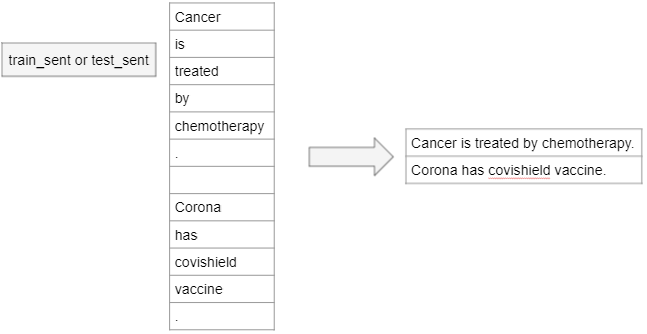

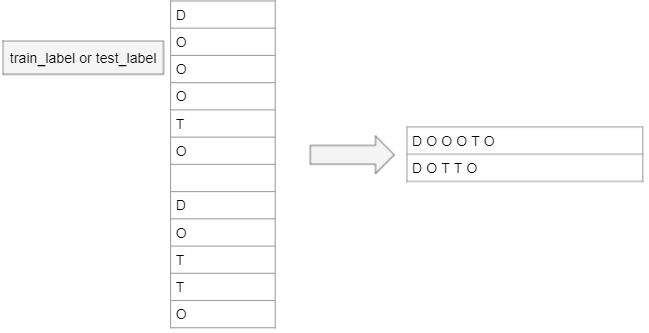

In [3]:
train_data = ''
train_sentences = []
train_sentence_words = []
with open('train_sent', 'r') as file:
    train_data = file.read()
    
for word in train_data.split('\n'):
    if(word != ''):
        train_sentence_words.append(word)
    else:
        train_sentences.append(' '.join(train_sentence_words))
        train_sentence_words.clear()
        
for i in range(0,5):
    print(train_sentences[i])

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


In [4]:
train_data = ''
train_labels = []
train_sentence_labels = []
with open('train_label', 'r') as file:
    train_data = file.read()
    #words.append(data)
    
for word in train_data.split('\n'):
    if(word != ''):
        train_sentence_labels.append(word)
    else:
        train_labels.append(' '.join(train_sentence_labels))
        train_sentence_labels.clear()
    
for i in range(0,5):
    print(train_labels[i])

O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O O O O


In [5]:
test_data = ''
test_sentences = []
test_sentence_words = []
with open('test_sent', 'r') as file:
    test_data = file.read()
    #words.append(data)
    
for word in test_data.split('\n'):
    if(word != ''):
        test_sentence_words.append(word)
    else:
        test_sentences.append(' '.join(test_sentence_words))
        test_sentence_words.clear()
        
for i in range(0,5):
    print(test_sentences[i])

Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period
There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )
Fluctuations in ambient temperature are inversely correlated to changes in AFI


In [6]:
test_data = ''
test_labels = []
test_sentence_labels = []
with open('test_label', 'r') as file:
    test_data = file.read()
    #words.append(data)
    
for word in test_data.split('\n'):
    if(word != ''):
        test_sentence_labels.append(word)
    else:
        test_labels.append(' '.join(test_sentence_labels))
        test_sentence_labels.clear()
    
for i in range(0,5):
    print(test_labels[i])

O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O


### Count the number of sentences in the processed train and test dataset 

In [7]:
print("Train sentence size: ", len(train_sentences))
print("Test sentence size: ", len(test_sentences))

Train sentence size:  2600
Test sentence size:  1057


### Count the number of lines of labels in the processed train and test dataset.

In [8]:
print("Train labels lines size: ", len(train_labels))
print("Test labels lines size: ", len(test_labels))

Train labels lines size:  2600
Test labels lines size:  1057


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [11]:
poss = ['NOUN','PROPN'] 
tokens = {}
for sent in (train_sentences + test_sentences):
    sent = model(sent)
    for token in sent:
        if token.pos_ in poss:
            if(tokens.get(token.pos_) is None):
                tokens[token.pos_] = {token.text:1}
            else:
                if token.text in tokens.get(token.pos_).keys():
                    tokens.get(token.pos_)[token.text] += 1
                else:
                    tokens.get(token.pos_)[token.text] = 1

print(tokens)

token_pos_count = {'NOUN' : len(tokens['NOUN']), 'PROPN': len(tokens['PROPN'])}
token_pos_count

{'NOUN': {'births': 2, 'weeks': 37, 'delivery': 20, 'route': 2, 'indication': 5, 'age': 56, 'parity': 4, 'practice': 31, 'group': 94, 'risk': 71, 'status': 17, 'rate': 67, '%': 247, 'presentation': 7, 'medicine': 36, 'patients': 492, 'Arrest': 1, 'dilation': 4, 'subgroups': 4, 'rates': 34, 'care': 56, 'hospitals': 10, 'community': 15, 'groups': 34, 'trimester': 4, 'fluid': 8, 'index': 13, 'temperature': 10, 'increases': 8, 'decrease': 5, 'period': 28, 'heat': 5, 'women': 77, 'singleton': 1, 'pregnancies': 7, 'gestation': 4, 'testing': 25, 'determinations': 2, 'ambient': 1, 'area': 11, 'day': 36, 'mean': 3, 'test': 20, 'date': 3, 'rank': 2, 'Correlation': 3, 'relationship': 12, 'account': 4, 'measure': 4, 'well': 1, 'being': 2, 'study': 154, 'population': 31, 'diabetes': 31, 'screening': 12, 'clinic': 5, 'year': 46, 'treatment': 281, 'week': 11, 'protocol': 5, 'control': 49, 'characteristics': 18, 'differences': 22, 'mode': 3, 'scores': 8, 'infants': 24, 'cases': 71, 'aim': 8, 'contribu

{'NOUN': 4913, 'PROPN': 1853}

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [32]:
from itertools import islice

for pos,token_dict in tokens.items():
    sorted_tokens = list(sorted(token_dict.items(), key = lambda item: item[1], reverse=True))
    print(pos," :", list(islice(sorted_tokens, None, 25)))

NOUN  : [('patients', 492), ('treatment', 281), ('%', 247), ('cancer', 200), ('therapy', 175), ('study', 154), ('disease', 142), ('cell', 140), ('lung', 115), ('group', 94), ('chemotherapy', 88), ('gene', 87), ('effects', 85), ('results', 79), ('women', 77), ('use', 74), ('risk', 71), ('cases', 71), ('surgery', 71), ('analysis', 70), ('rate', 67), ('response', 66), ('survival', 65), ('children', 64), ('effect', 63)]
PROPN  : [('TO_SEE', 74), ('HIV', 29), ('C', 27), ('METHODS', 26), ('A', 22), ('B', 22), ('preeclampsia', 19), ('S', 19), ('nsclc', 18), ('G', 17), ('CONCLUSION', 17), ('Group', 17), ('CO2', 17), ('II', 15), ('-', 14), ('International', 14), ('Study', 14), ('mg', 14), ('American', 14), ('AIDS', 14), ('L.', 13), ('Use', 13), ('interferon', 13), ('Hodgkin', 13), ('Parkinson', 12)]


### above was concept identification on the basis of different NOUN and PROPN tags, below is combined.

In [49]:
poss = ['NOUN','PROPN'] 
tokens = {}
for sent in (train_sentences + test_sentences):
    sent = model(sent)
    for token in sent:
        if token.pos_ in poss:
            if(tokens.get(token.text) is None):
                tokens[token.text] = 1
            else:
                tokens[token.text] += 1
                
                    
sorted_tokens = list(sorted(tokens.items(), key = lambda item: item[1], reverse=True))
print(list(islice(sorted_tokens, None, 25)))

[('patients', 492), ('treatment', 281), ('%', 247), ('cancer', 200), ('therapy', 175), ('study', 154), ('disease', 142), ('cell', 140), ('lung', 116), ('group', 94), ('chemotherapy', 88), ('gene', 87), ('effects', 85), ('results', 79), ('women', 77), ('use', 74), ('TO_SEE', 74), ('risk', 71), ('cases', 71), ('surgery', 71), ('analysis', 70), ('rate', 67), ('response', 66), ('survival', 65), ('children', 64)]


## Defining features for CRF





In [33]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]
    
    sent_processed = model(' '.join(sentence))
    pos_tags = []
    for tok in sent_processed:
        pos_tags.append(tok.pos_)
    
    features = [
        'word.lower=' + word.lower(), # serves as word id
        'word[-3:]=' + word[-3:],     # last three characters
        'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
        'word.pos=%s' % pos_tags[pos], # pos tag of word
        'word.isdigit=%s' % word.isdigit()  # is the word a number
    ]
    
    '''
    features = [
        'word.lower=' + word.lower(), # serves as word id
        'word[-3:]=' + word[-3:],     # last three characters
        'word[-2:]=' + word[-2:],     # last two characters
        'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),  # is the word a number
        'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
    ]
    '''

    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
            'prev_word.lower=' + prev_word.lower(), # serves as word id
            'prev_word[-3:]=' + prev_word[-3:],     # last three characters
            'prev_word.startsWithCapital=%s' % prev_word[0].isupper(), # is the word starting with a capital letter
            'prev_word.pos=%s' % pos_tags[pos-1], # pos tag of word
            'prev_word.isdigit=%s' % prev_word.isdigit()  # is the word a number
        ])
        '''
        features.extend([
            'prev_word.lower=' + prev_word.lower(), 
            'prev_word.isupper=%s' % prev_word.isupper(),
            'prev_word.isdigit=%s' % prev_word.isdigit(),
            'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
        ])
        '''
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [34]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [35]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [36]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]

In [37]:
print(X_train[25])
print(Y_train[25])

[['word.lower=severe', 'word[-3:]=ere', 'word.startsWithCapital=True', 'word.pos=ADJ', 'word.isdigit=False', 'BEG'], ['word.lower=preeclampsia', 'word[-3:]=sia', 'word.startsWithCapital=False', 'word.pos=NOUN', 'word.isdigit=False', 'prev_word.lower=severe', 'prev_word[-3:]=ere', 'prev_word.startsWithCapital=True', 'prev_word.pos=ADJ', 'prev_word.isdigit=False'], ['word.lower=was', 'word[-3:]=was', 'word.startsWithCapital=False', 'word.pos=AUX', 'word.isdigit=False', 'prev_word.lower=preeclampsia', 'prev_word[-3:]=sia', 'prev_word.startsWithCapital=False', 'prev_word.pos=NOUN', 'prev_word.isdigit=False'], ['word.lower=defined', 'word[-3:]=ned', 'word.startsWithCapital=False', 'word.pos=VERB', 'word.isdigit=False', 'prev_word.lower=was', 'prev_word[-3:]=was', 'prev_word.startsWithCapital=False', 'prev_word.pos=AUX', 'prev_word.isdigit=False'], ['word.lower=by', 'word[-3:]=by', 'word.startsWithCapital=False', 'word.pos=ADP', 'word.isdigit=False', 'prev_word.lower=defined', 'prev_word[-3:

### Define the labels as the target variable for test and the train dataset

In [38]:
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

In [39]:
print(X_test[258])
print(Y_test[258])
print(test_sentences[258])

[['word.lower=a', 'word[-3:]=A', 'word.startsWithCapital=True', 'word.pos=DET', 'word.isdigit=False', 'BEG'], ['word.lower=66-year-old', 'word[-3:]=old', 'word.startsWithCapital=False', 'word.pos=NUM', 'word.isdigit=False', 'prev_word.lower=a', 'prev_word[-3:]=A', 'prev_word.startsWithCapital=True', 'prev_word.pos=DET', 'prev_word.isdigit=False'], ['word.lower=male', 'word[-3:]=ale', 'word.startsWithCapital=False', 'word.pos=PUNCT', 'word.isdigit=False', 'prev_word.lower=66-year-old', 'prev_word[-3:]=old', 'prev_word.startsWithCapital=False', 'prev_word.pos=NUM', 'prev_word.isdigit=False'], ['word.lower=engineer', 'word[-3:]=eer', 'word.startsWithCapital=False', 'word.pos=NOUN', 'word.isdigit=False', 'prev_word.lower=male', 'prev_word[-3:]=ale', 'prev_word.startsWithCapital=False', 'prev_word.pos=PUNCT', 'prev_word.isdigit=False'], ['word.lower=diagnosed', 'word[-3:]=sed', 'word.startsWithCapital=False', 'word.pos=PUNCT', 'word.isdigit=False', 'prev_word.lower=engineer', 'prev_word[-3:

## Build the CRF Model

In [40]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [41]:
Y_pred = crf.predict(X_test)

In [47]:
print(Y_test[258])
print(Y_pred[258])

print(Y_test[46])
print(Y_pred[46])
print(X_test[46])

['O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D', 'O', 'O', 'O', 'O', 'T', 'T', 'T', 'T', 'T', 'T']
['O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D', 'O', 'O', 'O', 'O', 'T', 'T', 'T', 'T', 'T', 'T']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'O', 'O', 'O', 'O', 'O', 'T']
[['word.lower=<', 'word[-3:]=<', 'word.startsWithCapital=False', 'word.pos=X', 'word.isdigit=False', 'BEG'], ['word.lower=to_see', 'word[-3:]=SEE', 'word.startsWithCapital=True', 'word.pos=PROPN', 'word.isdigit=False', 'prev_word.lower=<', 'prev_word[-3:]=<', 'prev_word.startsWithCapital=False', 'prev_word.pos=X', 'prev_word.isdigit=False'], ['word.lower=>', 'word[-3:]=>', 'word.startsWithCapital=False', 'word.pos=X', 'word.isdigit=False', 'prev_word.lower=to_see', 'prev_word[-3:]=SEE', 'prev_word.startsWithCapital=True', 'prev_word.pos=PROPN', 'prev

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [43]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9077774375021231

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

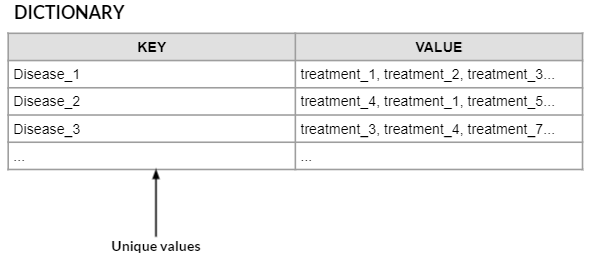

In [44]:
import re
d_T = {}
for i in range(0,len(Y_pred),1):
    label_st = ''.join(Y_pred[i])
    st = test_sentences[i]
    #print(st.split()[3:7])

    dS = re.search('(D)+', label_st)
    tS = re.search('(T)+', label_st)
    #print(tS.start(),tS.end())
    
    if (dS != None) & (tS != None):
        #print(tS)
        #print(dS)
        key = ' '.join(st.split()[int(dS.start()): int(dS.end())])
        value = [' '.join(st.split()[int(tS.start()): int(tS.end())])]
        if key in d_T.keys():
            d_T[key].extend(value)
        else:
            d_T[key] = value
    #print(re.search('(D\s)+', label_st).group())

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [45]:
#Showing dictionary of all diseases
d_T

{'hereditary retinoblastoma': ['radiotherapy'],
 'myocardial infarction': ['warfarin'],
 'unstable angina or non-Q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['Antichlamydial antibiotics'],
 'primary pulmonary hypertension': ['fenfluramines'],
 'cardiac disease': ['fenfluramine-phentermine'],
 "early Parkinson 's disease": ['Ropinirole monotherapy'],
 'abdominal tuberculosis': ['steroids'],
 'female stress urinary incontinence': ['surgical treatment'],
 'stress urinary incontinence': ['therapy'],
 'preeclampsia ( proteinuric hypertension': ['intrauterine insemination with donor sperm versus intrauterine insemination'],
 'intra-abdominal injury': ['celiotomy'],
 'severe acquired hyperammonemia': ['organ transplantation and chemotherapy'],
 'major pulmonary embolism': ['Thrombolytic treatment'],
 'malignant pleural mesothelioma': ['thoracotomy , radiotherapy , and chemotherapy'],
 'pulmonary symptoms': ['chemotherapy'],
 'non-obstructive azoospermia': ['t

In [46]:
#Showing treatment for 'hereditary retinoblastoma'
d_T['hereditary retinoblastoma']

['radiotherapy']